In [20]:
#pip install tsfresh
import pandas as pd
import yfinance as yf
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
import matplotlib.pyplot as plt
import seaborn as sns
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.feature_calculators import linear_trend_timewise
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

kompanii_ticker_kod = ["AMZN", "AAPL", "NKE", "PFE", "TSLA", "XOM"]
kompanii_iminja= ["Amazon", "Apple", "Nike","Pfizer","Tesla","ExxonMobil"]

poceten_datum = "2019-01-01"
kraen_datum = "2022-12-30"

# Simnuvanje na akciite so pomos na Yahoo Finance
akcii_celosna_data = yf.download(kompanii_ticker_kod, start=poceten_datum, end=kraen_datum, progress=False)
akcii_ceni = akcii_celosna_data["Adj Close"]

akcii_ceni.head()

,AAPL,AMZN,NKE,PFE,TSLA,XOM
Date,,,,,,
2019-01-02,37.943253,76.956497,70.848534,34.349560,20.674667,54.455967
2019-01-03,34.163822,75.014000,69.595329,33.388569,20.024000,53.619854
2019-01-04,35.622257,78.769501,71.412926,34.151005,21.179333,55.596809
2019-01-07,35.542969,81.475502,72.436546,34.333675,22.330667,55.885918
2019-01-08,36.220531,82.829002,73.402748,34.492519,22.356667,56.292259


In [21]:
# ESG scores za sekoja kompanija vo format "Timestamp", "AMZN", "AAPL", "XOM", "NKE", "PFE", "TSLA")
esg_scores = pd.read_csv('esg_scores.csv')

# Timestamp konverzija vo ist format kako Date od akciite
esg_scores['Timestamp'] = pd.to_datetime(esg_scores['Timestamp'], unit='s')

# Zimanje na site ESG scores od 2019-01-01 do 2022-12-30
esg_scores = esg_scores[(esg_scores['Timestamp'] >= poceten_datum) & (esg_scores['Timestamp'] <= kraen_datum)]

# Timestamp go stavame kako index na datasetot za da soodvestvuva na Date od akciite
esg_scores.set_index('Timestamp', inplace=True)

# Prosto popolnuvanje na ESG scores sto falat so sredna vrednost
esg_scores.fillna(esg_scores.mean(), inplace=True)

# Zapazuvanje na Date formatot - isto so Timestamp od ESG scores
akcii_ceni.index = pd.to_datetime(akcii_ceni.index)

# Trganje na datumite kade sto falat ceni na akcii ili ESC scores
zaednicki_datumi = akcii_ceni.index.intersection(esg_scores.index)
akcii_ceni = akcii_ceni.loc[zaednicki_datumi]
esg_scores = esg_scores.loc[zaednicki_datumi]

# Spojuvanje na cenite na akciite i ESG scores vo ist dataframe
df = akcii_ceni.merge(esg_scores, how='left', left_index=True, right_index=True)

kompanii = {
    'AAPL': 'Apple',
    'AMZN': 'Amazon',
    'NKE': 'Nike',
    'PFE': 'Pfizer',
    'TSLA': 'Tesla',
    'XOM': 'ExxonMobil',
    'AAPL_ESG_Score': 'Apple_ESG_Score',
    'AMZN_ESG_Score': 'Amazon_ESG_Score',
    'NKE_ESG_Score': 'Nike_ESG_Score',
    'PFE_ESG_Score': 'Pfizer_ESG_Score',
    'TSLA_ESG_Score': 'Tesla_ESG_Score',
    'XOM_ESG_Score': 'ExxonMobil_ESG_Score'
}
df.rename(columns=kompanii, inplace=True)
#Dodavanje na date kolonata
df.index.name = 'Date'
df.reset_index(inplace=True)

df.head()

,Date,Apple,Amazon,Nike,Pfizer,Tesla,ExxonMobil,Apple_ESG_Score,Amazon_ESG_Score,Nike_ESG_Score,Pfizer_ESG_Score,Tesla_ESG_Score,ExxonMobil_ESG_Score
0,2019-02-01,40.009567,81.311501,77.975479,34.353130,20.813999,59.324108,70.63,55.393051,62.540000,59.94,59.88,64.083239
1,2019-03-01,42.220131,83.586502,83.594986,34.737686,19.652666,63.206230,70.34,55.412542,62.592083,59.94,59.88,64.285070
2,2019-04-01,46.146076,90.709503,81.743935,34.321087,19.278667,64.573074,70.34,55.449167,62.577500,60.21,59.88,64.557286
3,2019-05-01,50.798325,95.575996,82.386528,32.662720,15.600667,62.155411,70.34,55.426667,62.651667,61.02,59.88,64.524429
4,2019-07-01,48.821163,96.109497,82.144577,35.377163,15.144667,61.181709,70.40,55.425000,62.550000,61.02,58.50,64.175857


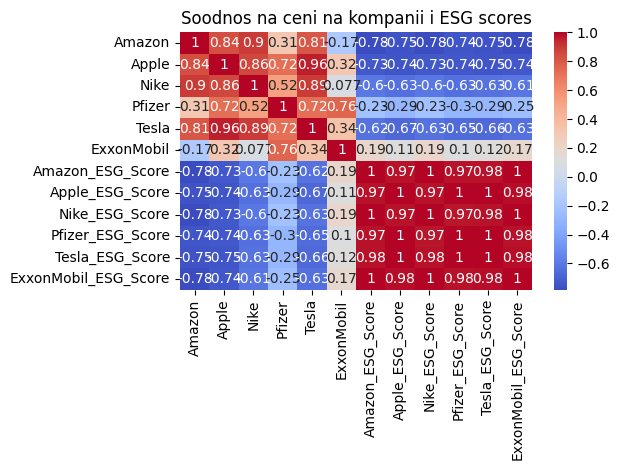

Feature Extraction: 100%|██████████| 360/360 [00:04<00:00, 72.10it/s]


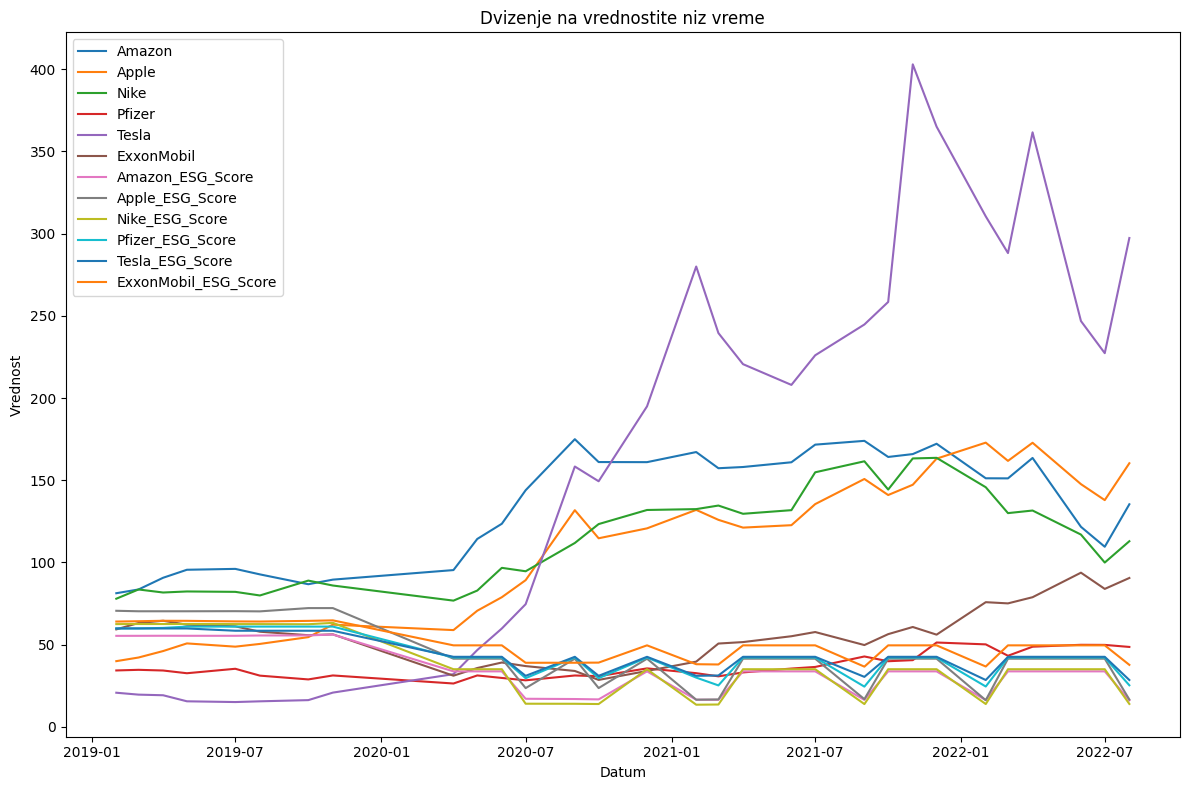

In [22]:

#Pravenje na matrica na korelacija
correlation_matrix = df[kompanii_iminja + [f'{c}_ESG_Score' for c in kompanii_iminja]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Soodnos na ceni na kompanii i ESG scores')
plt.tight_layout()
plt.show()

# Definitrame tip na izveduvanje na podatoci
extraction_settings = ComprehensiveFCParameters()

# Filtrirame samo trendovi potrebni
trend_feature_names = [
    "agg_linear_trend",
    "change_quantiles",
    "fft_coefficient",
    "linear_trend",
    "value_count"
]

filtered_extraction_settings = {
    feature_name: extraction_settings[feature_name]
    for feature_name in trend_feature_names
}

# Pravime ekstrahiranje preku tsfresh
trend_features = extract_features(
    df,
    column_id='Date',
    column_sort='Date',
    default_fc_parameters=filtered_extraction_settings
)
# Vtora vizuelizacija so pomosh na trend linii
columns_to_plot = kompanii_iminja + [f'{c}_ESG_Score' for c in kompanii_iminja]

# Kreiranje na liniite
plt.figure(figsize=(12, 8))
for column in columns_to_plot:
    plt.plot(df['Date'], df[column], label=column)

plt.xlabel('Datum')
plt.ylabel('Vrednost')
plt.title('Dvizenje na vrednostite niz vreme')
plt.legend()
plt.tight_layout()
plt.show()



Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.6397
Epoch 2/50
1/1 [==============================] - 0s 16ms/step - loss: 0.3675
Epoch 3/50
1/1 [==============================] - 0s 18ms/step - loss: 0.1712
Epoch 4/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0564
Epoch 5/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0469
Epoch 6/50
1/1 [==============================] - 0s 18ms/step - loss: 0.1126
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1297
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0963
Epoch 9/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0572
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0360
Epoch 11/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0340
Epoch 12/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0428
Epoch 13/50
1/1 [==============================] - 0s 28ms/step

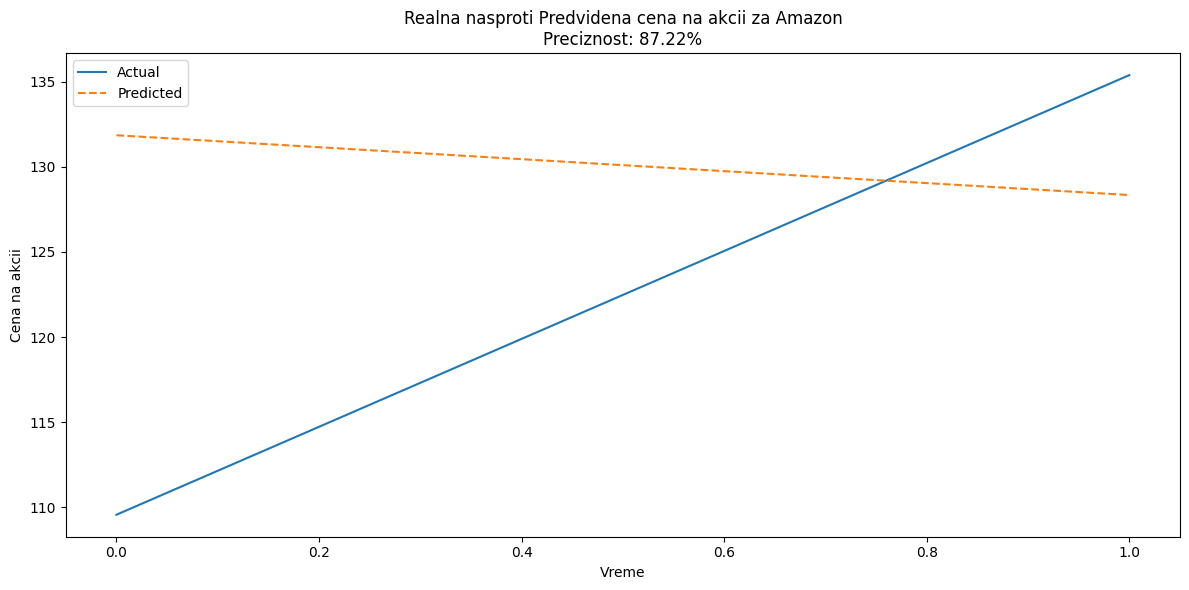

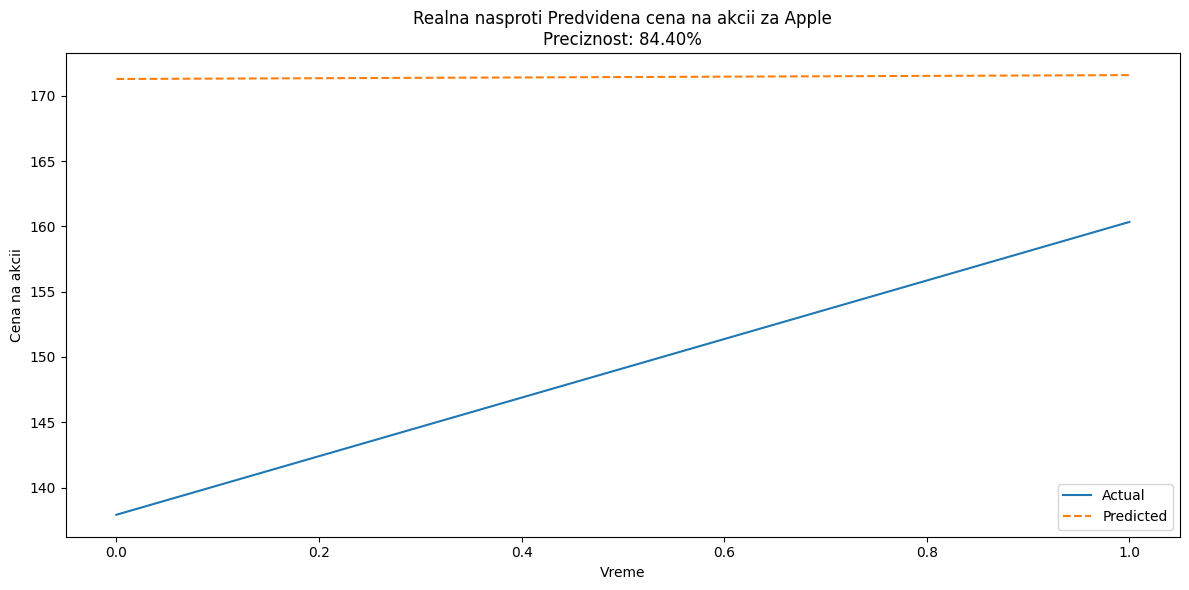

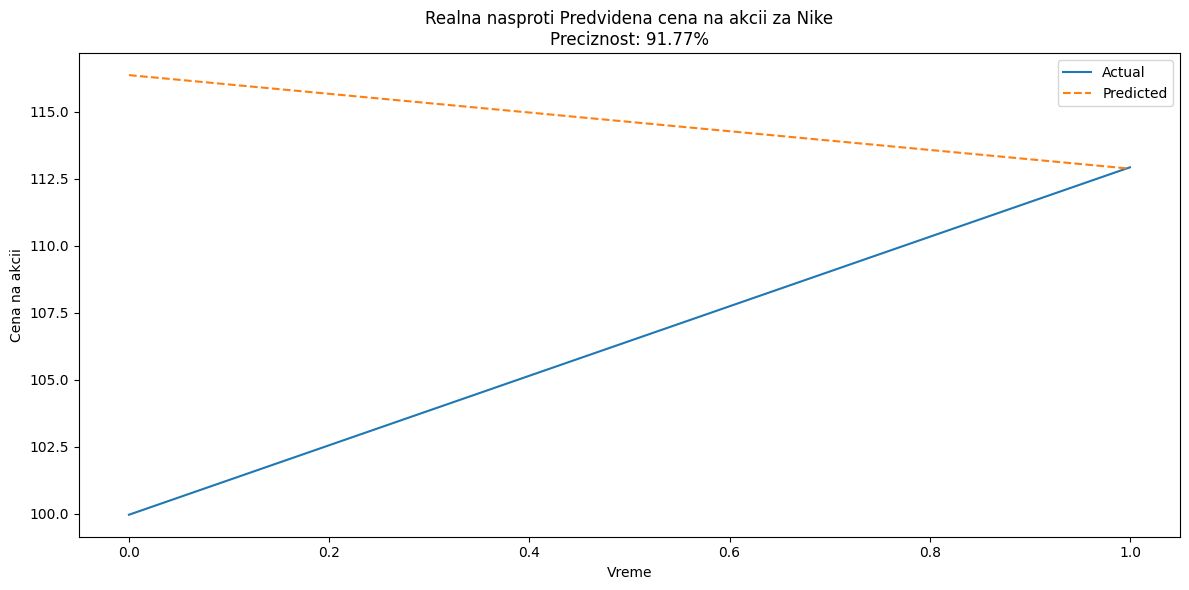

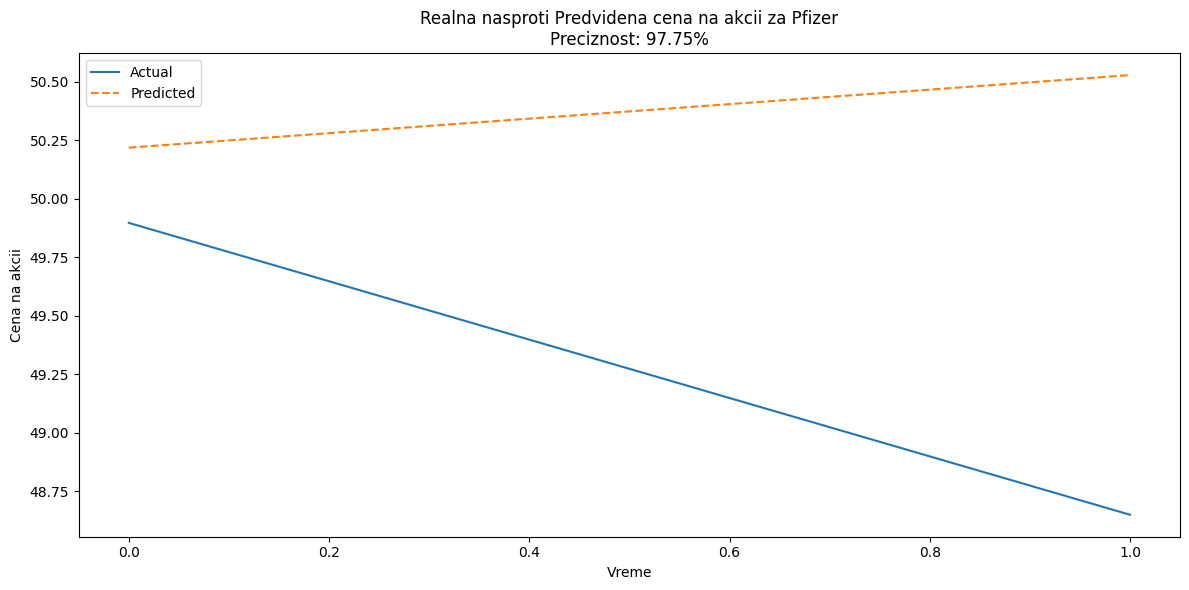

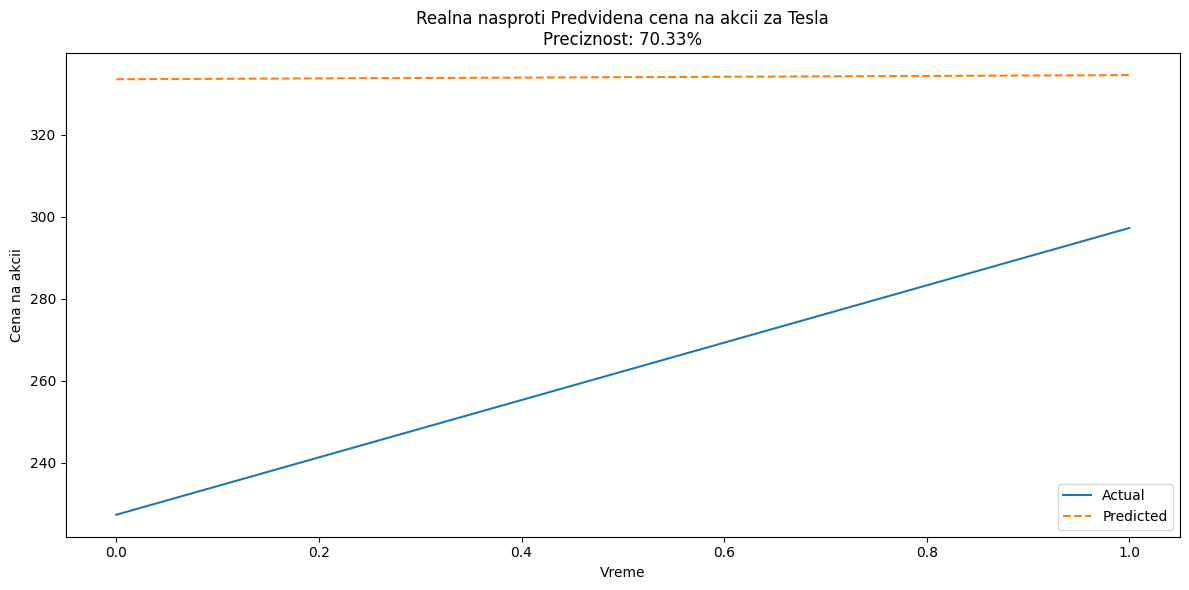

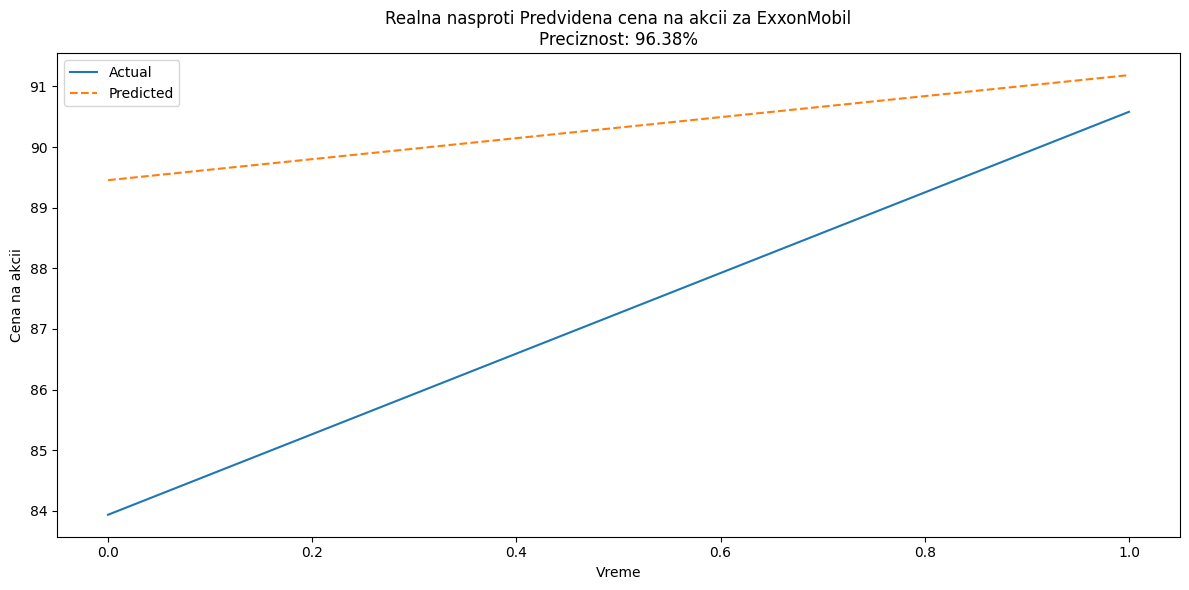

In [26]:

#Se koristi LSTM
sequence_length = 20  # You can adjust this value
lstm_units = 70  # You can adjust this value

# Se sozdavaat za da se cuvaat predikcii i rezultati
predikcii = {}
rezultati = {}

#Ja pominuvame sekoja kompanija
for kompanija in kompanii_iminja:
    #Definiranje na target koloni
    target = df[kompanija]
    features = df[kompanii_iminja + [f'{c}_ESG_Score' for c in kompanii_iminja]]

    # Normalizacija
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

    # Create sequences for LSTM training
    X = []
    y = []
    for i in range(len(features_scaled) - sequence_length):
        X.append(features_scaled[i:i+sequence_length])
        y.append(target_scaled[i+sequence_length])

    X = np.array(X)
    y = np.array(y)

    # Podelba vo train i test
    split_ratio = 0.8
    split_index = int(split_ratio * len(X))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Gradenje na model
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Se fituva modelot
    model.fit(X_train, y_train, epochs=50, batch_size=32)

    # Se pravat predikcii
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test)

    # Gi dodavame predikciite
    predikcii[kompanija] = {'actual': y_test_orig, 'predicted': y_pred}

 # Se presmetuva Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_orig - y_pred) / y_test_orig)) * 100

    # Se prikazuvaat rezultatite
    rezultati[kompanija] = {'actual': y_test_orig, 'predicted': y_pred, 'accuracy': 100 - mape}

# Pravime vizuelizacija na rezultatite
for kompanija, predviduvanje in rezultati.items():
    plt.figure(figsize=(12, 6))
    plt.plot(predviduvanje['actual'], label='Actual')
    plt.plot(predviduvanje['predicted'], label='Predicted', linestyle='dashed')
    plt.xlabel('Vreme')
    plt.ylabel('Cena na akcii')
    plt.title(f'Realna nasproti Predvidena cena na akcii za {kompanija}\nPreciznost: {predviduvanje["accuracy"]:.2f}%')
    plt.legend()
    plt.tight_layout()
    plt.show()




